In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from tensorflow.keras.metrics import AUC

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler

2025-05-15 19:21:42.134214: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from tensorflow.keras.models import load_model

# Build and Train CNN

In [2]:
def train(X,y,groups):

    # init for tracking
    all_models = []
    all_histories = []

    gkf = GroupKFold(n_splits=5, shuffle=True)    

    # using trainign data, holdout set reserved
    for ifold, (train_idx, val_idx) in enumerate(gkf.split(X, y, groups=groups)):
        print(f"\nRunning fold {ifold+1}/5")
        # get train and test data
        Xtr, Xval = X[train_idx], X[val_idx]
        ytr, yval = y[train_idx], y[val_idx]

        # Flatten time for scasling
        Xtr_reshaped = Xtr.reshape(-1, Xtr.shape[2]) # remove num_windows dimension for scaling
        Xval_reshaped = Xval.reshape(-1, Xval.shape[2])

        # scale
        scaler = StandardScaler()
        Xtr_scal = scaler.fit_transform(Xtr_reshaped).reshape(Xtr.shape) # restore original shape
        Xval_scal = scaler.transform(Xval_reshaped).reshape(Xval.shape)

        # define checkpoints
        # number of epochs with no improvment after which the training will stop
        early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=2)

        # save best model
        checkpoint = ModelCheckpoint(
        "model-epoch{epoch:02d}-valacc{val_accuracy:.2f}.keras", # save as .keras next time
        monitor="val_accuracy",
        save_best_only=True,
        verbose=2
    )

        # Build model  # input shape means a sinlge SAMple is of shape 200 rows * num features
        model = build_model(input_shape=(X.shape[1], X.shape[2]), num_classes=1)

        # compile
        model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', AUC(name='auc')])

        csv_logger = CSVLogger('training_log.csv', append=False) # to access metrics per epoch
        
        history = model.fit(
            Xtr_scal, ytr,
            validation_data=(Xval_scal, yval),
            epochs=20,
            batch_size=32, # 32 windows in 1 batch, with every batch per epoch, updates weights
            verbose=2,
            callbacks = [checkpoint, early_stopping, csv_logger]
        )

    all_models.append(model)
    all_histories.append(history)

    return all_models, all_histories


In [3]:
def build_model(input_shape=(500, 144), num_classes=1): # input: 144-length vectors with 500 timesteps

    model = models.Sequential([
        # First block: quarter-second time steps
        # kernel size = temporal width of the filter #filter size = num conv filters learned
        layers.Input(shape=input_shape),
        layers.Conv1D(32, kernel_size=25, padding='same', activation='relu'), #filter size = num conv filters learned
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        # 1-second time steps
        layers.Conv1D(64, kernel_size=50, dilation_rate=2, padding='same', activation='relu'), # padding = same, output shape remains 500. (500, 64)
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2), # downsamples by taking max activation(strongest patterns) 

        # 5-second time steps
        layers.Conv1D(128, kernel_size=50, dilation_rate=10, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2), 

        # summarize
        layers.GlobalAveragePooling1D(), # flattens
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),  # randomly zeroes out 32 of the 64 activations each epoch
        layers.Dense(num_classes, activation='sigmoid')  # binary classification
    ])

    return model


In [5]:
if __name__ == "__main__":
    # load data: 80% of preprocessed data with 20% saved for a holdout
    y = np.load("/home/sbinder3/wearables/y_train.npy")
    X = np.load("/home/sbinder3/wearables/X_train.npy")
    groups = np.load("/home/sbinder3/wearables/groups_train.npy")

    
    # call function
    models, histories = train(X,y,groups)


Epoch 1/20



Epoch 1: val_accuracy improved from -inf to 0.90202, saving model to model-epoch01-valacc0.90.keras


90/90 - 32s - 351ms/step - accuracy: 0.8082 - auc: 0.8811 - loss: 0.4725 - val_accuracy: 0.9020 - val_auc: 0.9657 - val_loss: 0.2671


Epoch 2/20



Epoch 2: val_accuracy improved from 0.90202 to 0.91066, saving model to model-epoch02-valacc0.91.keras


90/90 - 29s - 322ms/step - accuracy: 0.9231 - auc: 0.9747 - loss: 0.2011 - val_accuracy: 0.9107 - val_auc: 0.9672 - val_loss: 0.2517


Epoch 3/20



Epoch 3: val_accuracy improved from 0.91066 to 0.92363, saving model to model-epoch03-valacc0.92.keras


90/90 - 29s - 324ms/step - accuracy: 0.9462 - auc: 0.9851 - loss: 0.1505 - val_accuracy: 0.9236 - val_auc: 0.9746 - val_loss: 0.2185


Epoch 4/20



Epoch 4: val_accuracy improved from 0.92363 to 0.93516, saving model to model-epoch04-valacc0.94.keras


90/90 - 29s - 324ms/step - accuracy: 0.9619 - auc: 0.9928 - loss: 0.1049 - val_accuracy: 0.9352 - val_auc: 0.9773 - val_loss: 0.1971


Epoch 5/20



Epoch 5: val_accuracy improved from 0.93516 to 0.95965, saving model to model-epoch05-valacc0.96.keras


90/90 - 29s - 323ms/step - accuracy: 0.9644 - auc: 0.9935 - loss: 0.0952 - val_accuracy: 0.9597 - val_auc: 0.9878 - val_loss: 0.1440


Epoch 6/20



Epoch 6: val_accuracy improved from 0.95965 to 0.96542, saving model to model-epoch06-valacc0.97.keras


90/90 - 29s - 322ms/step - accuracy: 0.9787 - auc: 0.9972 - loss: 0.0607 - val_accuracy: 0.9654 - val_auc: 0.9928 - val_loss: 0.1165


Epoch 7/20



Epoch 7: val_accuracy did not improve from 0.96542


90/90 - 29s - 323ms/step - accuracy: 0.9867 - auc: 0.9979 - loss: 0.0465 - val_accuracy: 0.9654 - val_auc: 0.9825 - val_loss: 0.1700


Epoch 8/20



Epoch 8: val_accuracy did not improve from 0.96542


90/90 - 29s - 321ms/step - accuracy: 0.9846 - auc: 0.9979 - loss: 0.0491 - val_accuracy: 0.9625 - val_auc: 0.9874 - val_loss: 0.1446


Epoch 9/20



Epoch 9: val_accuracy improved from 0.96542 to 0.96830, saving model to model-epoch09-valacc0.97.keras


90/90 - 29s - 323ms/step - accuracy: 0.9825 - auc: 0.9970 - loss: 0.0524 - val_accuracy: 0.9683 - val_auc: 0.9867 - val_loss: 0.1466


Epoch 10/20



Epoch 10: val_accuracy did not improve from 0.96830


90/90 - 29s - 322ms/step - accuracy: 0.9867 - auc: 0.9985 - loss: 0.0367 - val_accuracy: 0.9669 - val_auc: 0.9884 - val_loss: 0.1377


Epoch 11/20



Epoch 11: val_accuracy did not improve from 0.96830


90/90 - 29s - 322ms/step - accuracy: 0.9871 - auc: 0.9988 - loss: 0.0388 - val_accuracy: 0.9669 - val_auc: 0.9883 - val_loss: 0.1415


Epoch 12/20



Epoch 12: val_accuracy did not improve from 0.96830


90/90 - 29s - 323ms/step - accuracy: 0.9860 - auc: 0.9980 - loss: 0.0440 - val_accuracy: 0.9683 - val_auc: 0.9892 - val_loss: 0.1247


Epoch 13/20



Epoch 13: val_accuracy did not improve from 0.96830


90/90 - 29s - 319ms/step - accuracy: 0.9899 - auc: 0.9985 - loss: 0.0340 - val_accuracy: 0.9524 - val_auc: 0.9927 - val_loss: 0.1351


Epoch 14/20



Epoch 14: val_accuracy did not improve from 0.96830


90/90 - 29s - 320ms/step - accuracy: 0.9895 - auc: 0.9988 - loss: 0.0301 - val_accuracy: 0.9524 - val_auc: 0.9907 - val_loss: 0.1396


Epoch 14: early stopping



Running fold 2/5


Epoch 1/20



Epoch 1: val_accuracy improved from -inf to 0.78830, saving model to model-epoch01-valacc0.79.keras


89/89 - 31s - 346ms/step - accuracy: 0.8203 - auc: 0.8975 - loss: 0.4333 - val_accuracy: 0.7883 - val_auc: 0.8925 - val_loss: 0.7838


Epoch 2/20



Epoch 2: val_accuracy improved from 0.78830 to 0.83983, saving model to model-epoch02-valacc0.84.keras


89/89 - 29s - 324ms/step - accuracy: 0.9214 - auc: 0.9767 - loss: 0.1948 - val_accuracy: 0.8398 - val_auc: 0.9282 - val_loss: 0.5717


Epoch 3/20



Epoch 3: val_accuracy improved from 0.83983 to 0.91365, saving model to model-epoch03-valacc0.91.keras


89/89 - 29s - 323ms/step - accuracy: 0.9567 - auc: 0.9906 - loss: 0.1199 - val_accuracy: 0.9136 - val_auc: 0.9599 - val_loss: 0.3083


Epoch 4/20



Epoch 4: val_accuracy did not improve from 0.91365


89/89 - 29s - 323ms/step - accuracy: 0.9718 - auc: 0.9957 - loss: 0.0780 - val_accuracy: 0.8955 - val_auc: 0.9529 - val_loss: 0.4151


Epoch 5/20



Epoch 5: val_accuracy did not improve from 0.91365


89/89 - 29s - 323ms/step - accuracy: 0.9778 - auc: 0.9976 - loss: 0.0614 - val_accuracy: 0.8788 - val_auc: 0.9514 - val_loss: 0.4186


Epoch 6/20



Epoch 6: val_accuracy did not improve from 0.91365


89/89 - 29s - 323ms/step - accuracy: 0.9729 - auc: 0.9944 - loss: 0.0829 - val_accuracy: 0.8969 - val_auc: 0.9568 - val_loss: 0.3406


Epoch 7/20



Epoch 7: val_accuracy improved from 0.91365 to 0.91643, saving model to model-epoch07-valacc0.92.keras


89/89 - 29s - 324ms/step - accuracy: 0.9824 - auc: 0.9974 - loss: 0.0535 - val_accuracy: 0.9164 - val_auc: 0.9663 - val_loss: 0.3313


Epoch 8/20



Epoch 8: val_accuracy did not improve from 0.91643


89/89 - 29s - 323ms/step - accuracy: 0.9799 - auc: 0.9980 - loss: 0.0521 - val_accuracy: 0.9095 - val_auc: 0.9562 - val_loss: 0.3870


Epoch 9/20



Epoch 9: val_accuracy did not improve from 0.91643


89/89 - 29s - 322ms/step - accuracy: 0.9824 - auc: 0.9974 - loss: 0.0526 - val_accuracy: 0.9081 - val_auc: 0.9634 - val_loss: 0.3303


Epoch 10/20



Epoch 10: val_accuracy improved from 0.91643 to 0.93733, saving model to model-epoch10-valacc0.94.keras


89/89 - 29s - 322ms/step - accuracy: 0.9891 - auc: 0.9994 - loss: 0.0315 - val_accuracy: 0.9373 - val_auc: 0.9715 - val_loss: 0.2840


Epoch 11/20



Epoch 11: val_accuracy did not improve from 0.93733


89/89 - 29s - 324ms/step - accuracy: 0.9817 - auc: 0.9970 - loss: 0.0570 - val_accuracy: 0.9150 - val_auc: 0.9646 - val_loss: 0.2973


Epoch 12/20



Epoch 12: val_accuracy did not improve from 0.93733


89/89 - 29s - 323ms/step - accuracy: 0.9803 - auc: 0.9977 - loss: 0.0557 - val_accuracy: 0.9359 - val_auc: 0.9682 - val_loss: 0.2670


Epoch 13/20



Epoch 13: val_accuracy improved from 0.93733 to 0.95543, saving model to model-epoch13-valacc0.96.keras


89/89 - 29s - 323ms/step - accuracy: 0.9891 - auc: 0.9991 - loss: 0.0312 - val_accuracy: 0.9554 - val_auc: 0.9756 - val_loss: 0.2152


Epoch 14/20



Epoch 14: val_accuracy did not improve from 0.95543


89/89 - 29s - 323ms/step - accuracy: 0.9926 - auc: 0.9994 - loss: 0.0222 - val_accuracy: 0.9415 - val_auc: 0.9703 - val_loss: 0.2974


Epoch 15/20



Epoch 15: val_accuracy did not improve from 0.95543


89/89 - 29s - 322ms/step - accuracy: 0.9841 - auc: 0.9961 - loss: 0.0529 - val_accuracy: 0.9290 - val_auc: 0.9733 - val_loss: 0.2508


Epoch 16/20



Epoch 16: val_accuracy did not improve from 0.95543


89/89 - 29s - 323ms/step - accuracy: 0.9933 - auc: 0.9989 - loss: 0.0256 - val_accuracy: 0.9164 - val_auc: 0.9575 - val_loss: 0.3942


Epoch 17/20



Epoch 17: val_accuracy did not improve from 0.95543


89/89 - 29s - 322ms/step - accuracy: 0.9831 - auc: 0.9973 - loss: 0.0565 - val_accuracy: 0.9331 - val_auc: 0.9681 - val_loss: 0.3140


Epoch 18/20



Epoch 18: val_accuracy did not improve from 0.95543


89/89 - 29s - 322ms/step - accuracy: 0.9880 - auc: 0.9985 - loss: 0.0377 - val_accuracy: 0.9401 - val_auc: 0.9756 - val_loss: 0.2461


Epoch 18: early stopping



Running fold 3/5


Epoch 1/20



Epoch 1: val_accuracy improved from -inf to 0.84719, saving model to model-epoch01-valacc0.85.keras


88/88 - 31s - 351ms/step - accuracy: 0.7929 - auc: 0.8802 - loss: 0.4675 - val_accuracy: 0.8472 - val_auc: 0.9094 - val_loss: 0.6056


Epoch 2/20



Epoch 2: val_accuracy improved from 0.84719 to 0.87802, saving model to model-epoch02-valacc0.88.keras


88/88 - 29s - 328ms/step - accuracy: 0.9295 - auc: 0.9809 - loss: 0.1765 - val_accuracy: 0.8780 - val_auc: 0.9465 - val_loss: 0.3357


Epoch 3/20



Epoch 3: val_accuracy improved from 0.87802 to 0.90080, saving model to model-epoch03-valacc0.90.keras


88/88 - 29s - 327ms/step - accuracy: 0.9516 - auc: 0.9888 - loss: 0.1328 - val_accuracy: 0.9008 - val_auc: 0.9656 - val_loss: 0.2866


Epoch 4/20



Epoch 4: val_accuracy improved from 0.90080 to 0.91153, saving model to model-epoch04-valacc0.91.keras


88/88 - 29s - 326ms/step - accuracy: 0.9669 - auc: 0.9955 - loss: 0.0846 - val_accuracy: 0.9115 - val_auc: 0.9605 - val_loss: 0.3324


Epoch 5/20



Epoch 5: val_accuracy did not improve from 0.91153


88/88 - 29s - 325ms/step - accuracy: 0.9701 - auc: 0.9952 - loss: 0.0819 - val_accuracy: 0.9088 - val_auc: 0.9474 - val_loss: 0.4255


Epoch 6/20



Epoch 6: val_accuracy did not improve from 0.91153


88/88 - 29s - 325ms/step - accuracy: 0.9705 - auc: 0.9960 - loss: 0.0794 - val_accuracy: 0.9115 - val_auc: 0.9618 - val_loss: 0.4120


Epoch 7/20



Epoch 7: val_accuracy improved from 0.91153 to 0.91823, saving model to model-epoch07-valacc0.92.keras


88/88 - 29s - 326ms/step - accuracy: 0.9819 - auc: 0.9970 - loss: 0.0545 - val_accuracy: 0.9182 - val_auc: 0.9606 - val_loss: 0.3357


Epoch 8/20



Epoch 8: val_accuracy improved from 0.91823 to 0.93834, saving model to model-epoch08-valacc0.94.keras


88/88 - 29s - 325ms/step - accuracy: 0.9861 - auc: 0.9992 - loss: 0.0364 - val_accuracy: 0.9383 - val_auc: 0.9697 - val_loss: 0.2488


Epoch 9/20



Epoch 9: val_accuracy did not improve from 0.93834


88/88 - 29s - 326ms/step - accuracy: 0.9840 - auc: 0.9981 - loss: 0.0445 - val_accuracy: 0.9303 - val_auc: 0.9658 - val_loss: 0.2883


Epoch 10/20



Epoch 10: val_accuracy did not improve from 0.93834


88/88 - 29s - 325ms/step - accuracy: 0.9879 - auc: 0.9983 - loss: 0.0407 - val_accuracy: 0.9383 - val_auc: 0.9724 - val_loss: 0.2973


Epoch 11/20



Epoch 11: val_accuracy improved from 0.93834 to 0.94370, saving model to model-epoch11-valacc0.94.keras


88/88 - 29s - 327ms/step - accuracy: 0.9822 - auc: 0.9964 - loss: 0.0554 - val_accuracy: 0.9437 - val_auc: 0.9838 - val_loss: 0.1810


Epoch 12/20



Epoch 12: val_accuracy improved from 0.94370 to 0.94906, saving model to model-epoch12-valacc0.95.keras


88/88 - 29s - 326ms/step - accuracy: 0.9918 - auc: 0.9988 - loss: 0.0307 - val_accuracy: 0.9491 - val_auc: 0.9838 - val_loss: 0.1848


Epoch 13/20



Epoch 13: val_accuracy did not improve from 0.94906


88/88 - 29s - 325ms/step - accuracy: 0.9907 - auc: 0.9992 - loss: 0.0267 - val_accuracy: 0.9397 - val_auc: 0.9708 - val_loss: 0.2678


Epoch 14/20



Epoch 14: val_accuracy did not improve from 0.94906


88/88 - 29s - 325ms/step - accuracy: 0.9890 - auc: 0.9981 - loss: 0.0414 - val_accuracy: 0.9196 - val_auc: 0.9670 - val_loss: 0.3179


Epoch 15/20



Epoch 15: val_accuracy did not improve from 0.94906


88/88 - 29s - 324ms/step - accuracy: 0.9943 - auc: 0.9999 - loss: 0.0141 - val_accuracy: 0.9383 - val_auc: 0.9670 - val_loss: 0.3047


Epoch 16/20



Epoch 16: val_accuracy did not improve from 0.94906


88/88 - 29s - 327ms/step - accuracy: 0.9868 - auc: 0.9970 - loss: 0.0476 - val_accuracy: 0.9370 - val_auc: 0.9696 - val_loss: 0.2589


Epoch 17/20



Epoch 17: val_accuracy did not improve from 0.94906


88/88 - 29s - 326ms/step - accuracy: 0.9954 - auc: 0.9999 - loss: 0.0158 - val_accuracy: 0.9357 - val_auc: 0.9662 - val_loss: 0.3077


Epoch 17: early stopping



Running fold 4/5


Epoch 1/20



Epoch 1: val_accuracy improved from -inf to 0.72096, saving model to model-epoch01-valacc0.72.keras


90/90 - 31s - 348ms/step - accuracy: 0.8084 - auc: 0.8774 - loss: 0.4906 - val_accuracy: 0.7210 - val_auc: 0.9250 - val_loss: 0.9983


Epoch 2/20



Epoch 2: val_accuracy improved from 0.72096 to 0.86261, saving model to model-epoch02-valacc0.86.keras


90/90 - 29s - 322ms/step - accuracy: 0.9249 - auc: 0.9762 - loss: 0.1999 - val_accuracy: 0.8626 - val_auc: 0.9654 - val_loss: 0.6087


Epoch 3/20



Epoch 3: val_accuracy improved from 0.86261 to 0.91643, saving model to model-epoch03-valacc0.92.keras


90/90 - 29s - 324ms/step - accuracy: 0.9421 - auc: 0.9825 - loss: 0.1648 - val_accuracy: 0.9164 - val_auc: 0.9796 - val_loss: 0.3009


Epoch 4/20



Epoch 4: val_accuracy did not improve from 0.91643


90/90 - 29s - 322ms/step - accuracy: 0.9684 - auc: 0.9941 - loss: 0.0915 - val_accuracy: 0.9023 - val_auc: 0.9651 - val_loss: 0.4918


Epoch 5/20



Epoch 5: val_accuracy improved from 0.91643 to 0.92068, saving model to model-epoch05-valacc0.92.keras


90/90 - 29s - 325ms/step - accuracy: 0.9723 - auc: 0.9945 - loss: 0.0850 - val_accuracy: 0.9207 - val_auc: 0.9810 - val_loss: 0.3283


Epoch 6/20



Epoch 6: val_accuracy improved from 0.92068 to 0.93626, saving model to model-epoch06-valacc0.94.keras


90/90 - 29s - 323ms/step - accuracy: 0.9733 - auc: 0.9959 - loss: 0.0748 - val_accuracy: 0.9363 - val_auc: 0.9801 - val_loss: 0.2460


Epoch 7/20



Epoch 7: val_accuracy improved from 0.93626 to 0.95184, saving model to model-epoch07-valacc0.95.keras


90/90 - 29s - 323ms/step - accuracy: 0.9811 - auc: 0.9974 - loss: 0.0567 - val_accuracy: 0.9518 - val_auc: 0.9773 - val_loss: 0.2303


Epoch 8/20



Epoch 8: val_accuracy did not improve from 0.95184


90/90 - 29s - 321ms/step - accuracy: 0.9740 - auc: 0.9954 - loss: 0.0758 - val_accuracy: 0.9433 - val_auc: 0.9819 - val_loss: 0.1883


Epoch 9/20



Epoch 9: val_accuracy did not improve from 0.95184


90/90 - 29s - 321ms/step - accuracy: 0.9796 - auc: 0.9969 - loss: 0.0643 - val_accuracy: 0.9334 - val_auc: 0.9829 - val_loss: 0.1777


Epoch 10/20



Epoch 10: val_accuracy did not improve from 0.95184


90/90 - 29s - 322ms/step - accuracy: 0.9418 - auc: 0.9826 - loss: 0.1659 - val_accuracy: 0.9348 - val_auc: 0.9742 - val_loss: 0.2687


Epoch 11/20



Epoch 11: val_accuracy did not improve from 0.95184


90/90 - 29s - 321ms/step - accuracy: 0.9719 - auc: 0.9931 - loss: 0.0858 - val_accuracy: 0.9306 - val_auc: 0.9784 - val_loss: 0.2396


Epoch 12/20



Epoch 12: val_accuracy did not improve from 0.95184


90/90 - 29s - 322ms/step - accuracy: 0.9877 - auc: 0.9992 - loss: 0.0353 - val_accuracy: 0.9476 - val_auc: 0.9875 - val_loss: 0.1649


Epoch 12: early stopping



Running fold 5/5


Epoch 1/20



Epoch 1: val_accuracy improved from -inf to 0.83671, saving model to model-epoch01-valacc0.84.keras


90/90 - 31s - 349ms/step - accuracy: 0.7828 - auc: 0.8617 - loss: 0.4966 - val_accuracy: 0.8367 - val_auc: 0.9067 - val_loss: 0.6801


Epoch 2/20



Epoch 2: val_accuracy improved from 0.83671 to 0.92197, saving model to model-epoch02-valacc0.92.keras


90/90 - 29s - 325ms/step - accuracy: 0.9186 - auc: 0.9755 - loss: 0.2002 - val_accuracy: 0.9220 - val_auc: 0.9744 - val_loss: 0.2117


Epoch 3/20



Epoch 3: val_accuracy did not improve from 0.92197


90/90 - 29s - 323ms/step - accuracy: 0.9543 - auc: 0.9902 - loss: 0.1250 - val_accuracy: 0.9220 - val_auc: 0.9778 - val_loss: 0.2002


Epoch 4/20



Epoch 4: val_accuracy improved from 0.92197 to 0.94364, saving model to model-epoch04-valacc0.94.keras


90/90 - 29s - 325ms/step - accuracy: 0.9571 - auc: 0.9896 - loss: 0.1206 - val_accuracy: 0.9436 - val_auc: 0.9883 - val_loss: 0.1451


Epoch 5/20



Epoch 5: val_accuracy improved from 0.94364 to 0.94942, saving model to model-epoch05-valacc0.95.keras


90/90 - 29s - 324ms/step - accuracy: 0.9787 - auc: 0.9969 - loss: 0.0684 - val_accuracy: 0.9494 - val_auc: 0.9840 - val_loss: 0.1763


Epoch 6/20



Epoch 6: val_accuracy did not improve from 0.94942


90/90 - 29s - 323ms/step - accuracy: 0.9773 - auc: 0.9980 - loss: 0.0570 - val_accuracy: 0.9220 - val_auc: 0.9687 - val_loss: 0.2794


Epoch 7/20



Epoch 7: val_accuracy did not improve from 0.94942


90/90 - 29s - 324ms/step - accuracy: 0.9811 - auc: 0.9967 - loss: 0.0643 - val_accuracy: 0.9350 - val_auc: 0.9687 - val_loss: 0.2622


Epoch 8/20



Epoch 8: val_accuracy improved from 0.94942 to 0.95376, saving model to model-epoch08-valacc0.95.keras


90/90 - 29s - 325ms/step - accuracy: 0.9797 - auc: 0.9979 - loss: 0.0531 - val_accuracy: 0.9538 - val_auc: 0.9858 - val_loss: 0.1654


Epoch 9/20



Epoch 9: val_accuracy did not improve from 0.95376


90/90 - 29s - 323ms/step - accuracy: 0.9784 - auc: 0.9972 - loss: 0.0593 - val_accuracy: 0.9480 - val_auc: 0.9702 - val_loss: 0.3018


Epoch 10/20



Epoch 10: val_accuracy did not improve from 0.95376


90/90 - 29s - 323ms/step - accuracy: 0.9902 - auc: 0.9993 - loss: 0.0274 - val_accuracy: 0.9220 - val_auc: 0.9550 - val_loss: 0.3547


Epoch 11/20



Epoch 11: val_accuracy did not improve from 0.95376


90/90 - 29s - 323ms/step - accuracy: 0.9846 - auc: 0.9975 - loss: 0.0460 - val_accuracy: 0.9451 - val_auc: 0.9843 - val_loss: 0.1652


Epoch 12/20



Epoch 12: val_accuracy did not improve from 0.95376


90/90 - 29s - 323ms/step - accuracy: 0.9899 - auc: 0.9991 - loss: 0.0307 - val_accuracy: 0.9509 - val_auc: 0.9781 - val_loss: 0.2139


Epoch 13/20



Epoch 13: val_accuracy improved from 0.95376 to 0.95954, saving model to model-epoch13-valacc0.96.keras


90/90 - 29s - 324ms/step - accuracy: 0.9895 - auc: 0.9991 - loss: 0.0331 - val_accuracy: 0.9595 - val_auc: 0.9847 - val_loss: 0.1483


Epoch 14/20



Epoch 14: val_accuracy did not improve from 0.95954


90/90 - 29s - 323ms/step - accuracy: 0.9895 - auc: 0.9987 - loss: 0.0344 - val_accuracy: 0.9379 - val_auc: 0.9743 - val_loss: 0.2459


Epoch 15/20



Epoch 15: val_accuracy did not improve from 0.95954


90/90 - 29s - 323ms/step - accuracy: 0.9846 - auc: 0.9979 - loss: 0.0462 - val_accuracy: 0.9595 - val_auc: 0.9855 - val_loss: 0.1518


Epoch 16/20



Epoch 16: val_accuracy improved from 0.95954 to 0.96098, saving model to model-epoch16-valacc0.96.keras


90/90 - 29s - 324ms/step - accuracy: 0.9916 - auc: 0.9993 - loss: 0.0239 - val_accuracy: 0.9610 - val_auc: 0.9875 - val_loss: 0.1400


Epoch 17/20



Epoch 17: val_accuracy did not improve from 0.96098


90/90 - 29s - 323ms/step - accuracy: 0.9895 - auc: 0.9991 - loss: 0.0306 - val_accuracy: 0.9610 - val_auc: 0.9874 - val_loss: 0.1566


Epoch 18/20



Epoch 18: val_accuracy improved from 0.96098 to 0.96387, saving model to model-epoch18-valacc0.96.keras


90/90 - 29s - 324ms/step - accuracy: 0.9934 - auc: 0.9995 - loss: 0.0195 - val_accuracy: 0.9639 - val_auc: 0.9861 - val_loss: 0.1726


Epoch 19/20



Epoch 19: val_accuracy did not improve from 0.96387


90/90 - 29s - 324ms/step - accuracy: 0.9913 - auc: 0.9996 - loss: 0.0240 - val_accuracy: 0.9538 - val_auc: 0.9775 - val_loss: 0.2309


Epoch 20/20



Epoch 20: val_accuracy did not improve from 0.96387


90/90 - 29s - 323ms/step - accuracy: 0.9930 - auc: 0.9995 - loss: 0.0188 - val_accuracy: 0.9465 - val_auc: 0.9736 - val_loss: 0.2469


# Evaluate


In [33]:
#model.summary()

In [6]:
# load holdout set
y_test = np.load("/home/sbinder3/wearables/y_test.npy")
X_test = np.load("/home/sbinder3/wearables/X_test.npy")
X_train = np.load("/home/sbinder3/wearables/X_train.npy")

In [10]:
# refit scaler on trianing set (to get same)
scaler = StandardScaler()
xtr_reshaped = X_train.reshape(-1, X_train.shape[2])
scaler.fit(xtr_reshaped)

StandardScaler()

In [11]:
# load best model
model = load_model("model-epoch09-valacc0.97.keras")

# scale test set
xts_reshaped = X_test.reshape(-1, X_test.shape[2])
xts_scaled = scaler.transform(xts_reshaped).reshape(X_test.shape)

# compile
model.compile(optimizer='adam',
      loss='binary_crossentropy',
      metrics=['accuracy', AUC(name='auc')])

results = model.evaluate(xts_scaled, y_test, verbose=2)
print(f"Test Accuracy: {results[1]:.4f}")
print(f"Test AUC: {results[2]:.4f}")


29/29 - 2s - 81ms/step - accuracy: 0.9035 - auc: 0.9541 - loss: 5.4050
Test Accuracy: 0.9035
Test AUC: 0.9541


29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step


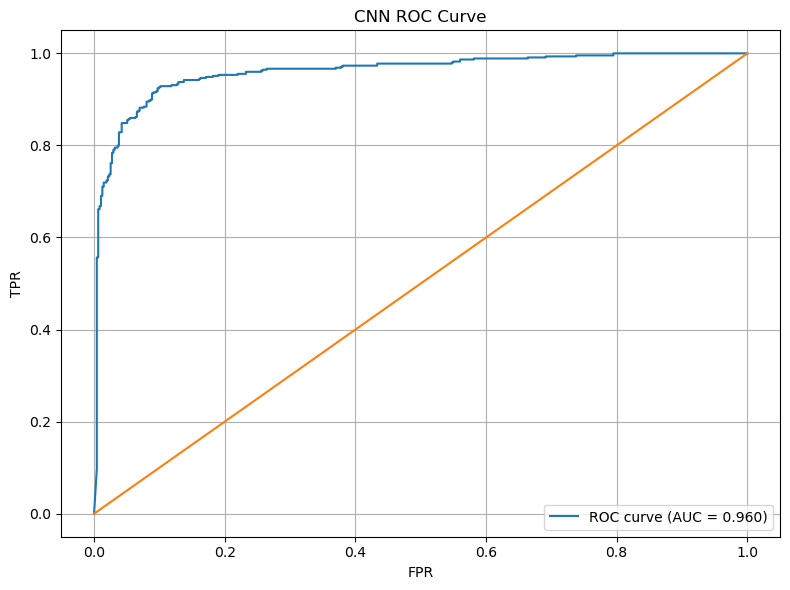

In [13]:
# AUC Plot

# calc probabilities
y_probs = model.predict(xts_scaled)

fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc_score = roc_auc_score(y_test, y_probs)

# vis
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc_score:.3f})")
plt.plot([0, 1], [0, 1])
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("CNN ROC Curve")
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Prev versions

In [ ]:
# def train(X,y,groups):

#     # init for tracking
#     all_models = []
#     all_histories = []

#     gkf = GroupKFold(n_splits=5, shuffle=True)    

#     # using trainign data, holdout set reserved
#     for ifold, (train_idx, val_idx) in enumerate(gkf.split(X, y, groups=groups)):
#         print(f"\nRunning fold {ifold+1}/5")
#         # get train and test data
#         Xtr, Xval = X[train_idx], X[val_idx]
#         ytr, yval = y[train_idx], y[val_idx]

#         # Flatten time for scasling
#         Xtr_reshaped = Xtr.reshape(-1, Xtr.shape[2]) # remove num_windows dimension for scaling
#         Xval_reshaped = Xval.reshape(-1, Xval.shape[2])

#         # scale
#         scaler = StandardScaler()
#         Xtr_scal = scaler.fit_transform(Xtr_reshaped).reshape(Xtr.shape) # restore original shape
#         Xval_scal = scaler.transform(Xval_reshaped).reshape(Xval.shape)

#         # define checkpoints
#         # number of epochs with no improvment after which the training will stop
#         early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=2)

#         # save best model
#         checkpoint = ModelCheckpoint(
#         "model-epoch{epoch:02d}-valacc{val_accuracy:.2f}.keras", # save as .keras next time
#         monitor="val_accuracy",
#         save_best_only=True,
#         verbose=2
#     )

#         # Build model  # input shape means a sinlge SAMple is of shape 200 rows * num features
#         model = build_model(input_shape=(X.shape[1], X.shape[2]), num_classes=1)

#         # compile
#         model.compile(optimizer='adam',
#               loss='binary_crossentropy',
#               metrics=['accuracy', AUC(name='auc')])

#         csv_logger = CSVLogger('training_log.csv', append=False) # to access metrics per epoch
        
#         history = model.fit(
#             Xtr_scal, ytr,
#             validation_data=(Xval_scal, yval),
#             epochs=20,
#             batch_size=32, # 32 windows in 1 batch, with every batch per epoch, updates weights
#             verbose=2,
#             callbacks = [checkpoint, early_stopping, csv_logger]
#         )

#     all_models.append(model)
#     all_histories.append(history)

#     return all_models, all_histories


In [9]:
# X = np.array(all_X)
# y = np.array(all_y)
# groups = np.array(all_groups)

# def train(X,y,groups):

#     # init for tracking
#     all_models = []
#     all_histories = []

#     gkf = GroupKFold(n_splits=5, shuffle=True)     # data shuffle?
    
#     for ifold, (train_idx, val_idx) in enumerate(gkf.split(X, y, groups=groups)):
#         print(f"\nRunning fold {ifold_+1}/5")
#         # get train and test data
#         Xtr, Xval = X[train_idx], X[val_idx]
#         ytr, yval = y[train_idx], y[val_idx]

#         #scale
#         scaler = StandardScaler()
#         Xtr_scal = scaler.fit_transform(Xtr)
#         Xval_scal = scaler.transform(Xval)

#         # define checkpoints
#         # number of epochs with no improvment after which the training will stop
#         early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)
        
#         # save best model
#         checkpoint = ModelCheckpoint(
#         "model-epoch{epoch:02d}-valacc{val_accuracy:.2f}.h5",
#         monitor="val_accuracy",
#         save_best_only=True,
#         verbose=2
#     )

#         # Build model  # input shape means a sinlge SAMple is of shape 200 rows * num features
#         model = build_model(input_shape=(X.shape[1], X.shape[2]), num_classes=3) 

#         # compile
#         model.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])
    
#         model.fit(
#             Xtr_scal, ytr
#             validation_data=(Xval_scal, yval),
#             epochs=20,
#             batch_size=32,
#             verbose=2,
#             callbacks = [checkpoint, early_stopping]
#         )

#     all_models.append(model)
#     all_histories.append(history)

#     return all_models, all_histories


In [10]:
# def build_model(input_shape=(200, 162), num_classes=3): # input: 162-length vectors with 200 timesteps # BATCH size?
    
#     model = models.Sequential([
#         # First block: half-second time steps
#         # kernel size = temporal width of the filter #filter size = num conv filters learned
#         layers.Conv1D(64, kernel_size=25, dilation_rate=2, padding='same', activation='relu', input_shape=input_shape)), #filter size = num conv filters learned 
#         layers.BatchNormalization(),
#         layers.Dropout(0.3),

#         # 1-second time steps
#         layers.Conv1D(128, kernel_size=50, dilation_rate=2, padding='same', activation='relu') # padding = same, output shape remains 200. (200, 128)
#         layers.BatchNormalization(),
#         layers.MaxPooling1D(pool_size=2), # downsamples by taking max activation(strongest patterns) # 200 > 100

#         # 2-second time steps
#         layers.Conv1D(128, kernel_size=50, dilation_rate=4, padding='same', activation='relu') 
#         layers.BatchNormalization(),
#         layers.MaxPooling1D(pool_size=2), # 100 > 50

#         # summarize
#         layers.GlobalAveragePooling1D(), # flattens
#         layers.Dense(64, activation='relu'),
#         layers.Dropout(0.5),  # randomly zeroes out 32 of the 64 activations each epoch
#         layers.Dense(num_classes, activation='softmax')  
#     ])
    
#     return model
